In [693]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
sys.path.append('../code/')
from time_series_plots import plot_time_series
np.random.seed(123)

In [694]:
df = pd.read_csv('../data/master_acd_gdp_ffr.csv', index_col='date', parse_dates=True)
df.drop(columns=['year', 'month'], inplace=True)
df.head()

,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,cc_payments_yoy,Mortgage_servicing_yoy,cc_bals_30d_due_percentage_yoy,cc_bals_90d_due_percentage_yoy,cc_bals_30d_due_percentage_yoy_3m,cc_bals_30d_due_percentage_yoy_6m,cc_bals_30d_due_percentage_6m,gdp,gdp_yoy,fedfunds
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,283960000.0,4.2,NaN,3.732227,3.252886,17.777778,4.538341,2.889825,13.143736,2.760736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10470.231000,4.679500,5.98
2001-02-01,284166000.0,4.2,NaN,3.533569,3.457307,13.110540,4.600390,3.006615,8.400292,0.200602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10513.154000,4.255523,5.49
2001-03-01,284380000.0,4.3,NaN,2.920561,3.496868,5.973813,4.540163,3.123123,-6.099935,-1.601602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10556.077000,3.838372,5.31
2001-04-01,284602000.0,4.4,NaN,3.269119,3.595623,10.273405,4.643963,3.181273,3.851262,-0.710660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10599.000000,3.427884,4.80
2001-05-01,284834000.0,4.3,NaN,3.615160,3.742204,15.785124,4.668210,3.108189,15.420561,-0.809717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10598.673333,3.188251,4.21


In [695]:
df.corr(numeric_only=True)['credit_yoy'].sort_values(ascending=False)

credit_yoy                                                       1.000000
shelter_yoy                                                      0.520146
Mortgage_servicing_yoy                                           0.458956
cpi_yoy                                                          0.448303
gdp_yoy                                                          0.384757
                                                                   ...   
total_personal_savings                                          -0.279951
personal_saving_as_a_percentage_of_disposable_personal_income   -0.306737
HE Revolving                                                    -0.360207
unemployment_insurance                                          -0.367702
unemployment_rate                                               -0.547609
Name: credit_yoy, Length: 66, dtype: float64

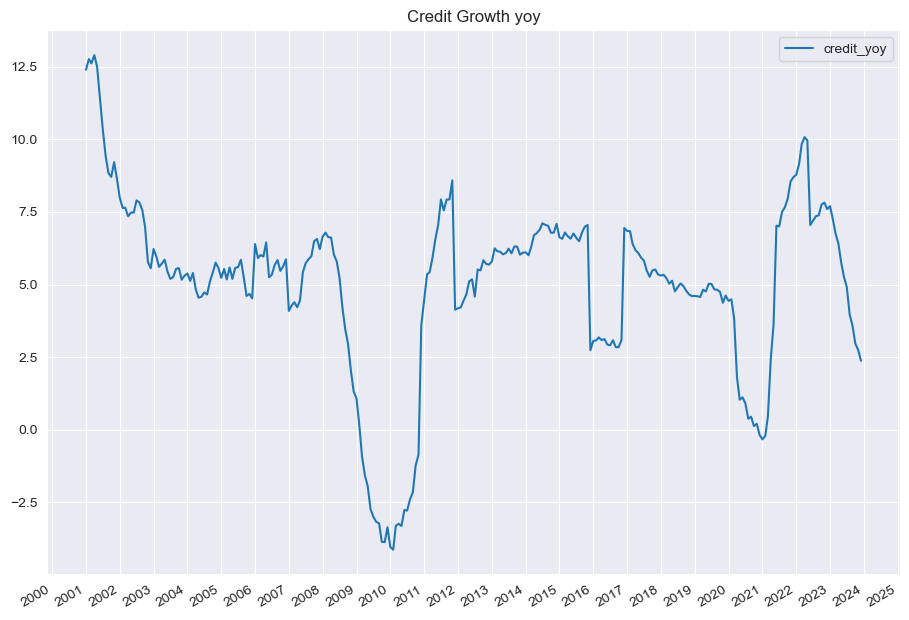

<Figure size 1000x600 with 0 Axes>

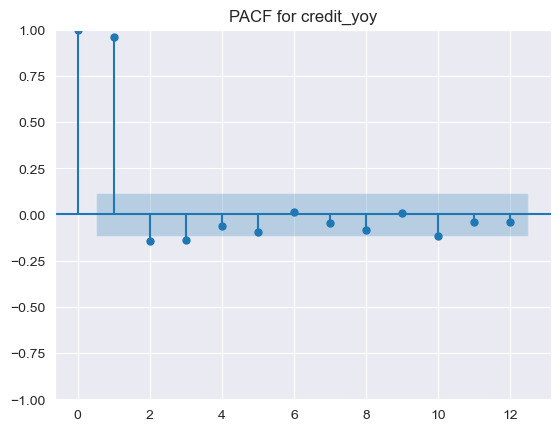

In [696]:
plot_time_series(df, columns = ['credit_yoy'],title = 'Credit Growth yoy', pacf=True);

First endogenous baseline model will use p of 1 based on the idea that:

"If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 PACF value is positive, choose $p$ to be the lag in the PACF before the cut-off. If the PACF does not have a sharp cut-off or the lag-1 ACF value is not positive, then let $p=0$."

q will equal 

In [697]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df['credit_yoy']))

Test Statistic   -2.840773
p-value           0.052681
dtype: float64

In [698]:
# lets do d = 1 based on below results
df_lag = df.copy()
df_lag['credit_yoy_lag1'] = df_lag['credit_yoy'].diff(1)
interpret_dftest(adfuller(df_lag['credit_yoy_lag1'].dropna()))

Test Statistic   -6.401630e+00
p-value           1.988921e-08
dtype: float64

d = 1 based on above p-value which is less when 0.05

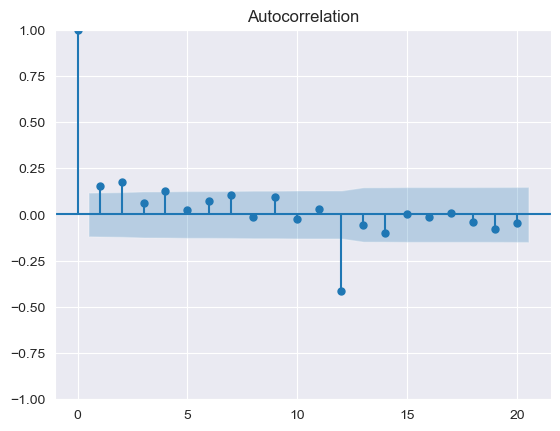

In [699]:
plot_acf(df_lag['credit_yoy_lag1'].dropna(), lags=20);

q will equal 0 because the first lag is positive, in the auto correlation function.

## Baseline ARIMA model 

In [700]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2001-01-01 to 2023-12-01
Data columns (total 68 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   population                                                       276 non-null    float64
 1   unemployment_rate                                                276 non-null    float64
 2   hourly_earnings_yoy                                              202 non-null    float64
 3   cpi_yoy                                                          276 non-null    float64
 4   shelter_yoy                                                      276 non-null    float64
 5   energy_yoy                                                       276 non-null    float64
 6   medical_care_yoy                                                 276 non-null    float64
 7   food_yoy                 

In [701]:
m_coliniarity = ['credit_yoy', 'cc_rate_all_ns', 
                'cc_bals_30d_due_percentage_6m', 
                'cc_bals_30d_due_percentage_yoy_6m',
                'cc_bals_30d_due_percentage_yoy_3m',
                'cc_bals_90d_due_percentage_yoy',
                'cc_bals_30d_due_percentage_yoy',
                'Mortgage_servicing_yoy',
                'cc_payments_yoy',
                'cc_payments',
                'Mortgage_servicing',
                'cc_bals_90d_due_percentage.1',
                'cc_bals_30d_due_percentage.1',
                'Total',
                'Other',
                'Student Loan',
                'Credit Card',
                'Auto Loan',
                'HE Revolving',
                'Mortgage',
                'Qtr',
                'cc_balance_total_billions',
                'cc_bals_90d_due_percentage',
                'cc_bals_30d_due_percentage',
                'hourly_earnings_yoy']
X_nonscaled = df.drop(columns=m_coliniarity)
y = df['credit_yoy']

In [702]:
# Standard scale X
ss = StandardScaler()

X = ss.fit_transform(X_nonscaled)
X = pd.DataFrame(X, index=X_nonscaled.index, columns=X_nonscaled.columns)
X.head()

,population,unemployment_rate,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,new_&_used_vehicles_yoy,...,total_all_personal_outlays,personal_interest_payments,tax_other_to_government,tax_personal_current,tax_gov_social_insurance_domestic,tax_total_all_taxes,mortgage_rate_30_yr,gdp,gdp_yoy,fedfunds
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,-1.859529,-0.831750,0.657358,0.163832,0.987939,1.006524,-0.009527,0.296820,0.148321,0.058582,...,-1.478936,-0.596289,-1.786493,-0.759218,-1.337861,-0.983301,1.651984,-1.470792,0.097003,2.512075
2001-02-01,-1.846451,-0.831750,0.548878,0.296281,0.640222,1.056895,0.042586,0.088003,-0.217255,0.147126,...,-1.474323,-0.597642,-1.771009,-0.734815,-1.321626,-0.961639,1.665901,-1.461407,-0.049874,2.231571
2001-03-01,-1.832865,-0.781085,0.214138,0.321913,0.108524,1.008003,0.094573,-0.550329,-0.474601,0.059189,...,-1.476019,-0.606907,-1.753865,-0.718281,-1.312443,-0.947407,1.587966,-1.452021,-0.194385,2.128528
2001-04-01,-1.818771,-0.730420,0.404472,0.385898,0.428851,1.092267,0.120520,-0.112255,-0.347379,-0.006890,...,-1.473431,-0.612410,-1.743358,-0.714807,-1.319961,-0.947401,1.687770,-1.442636,-0.336587,1.836574
2001-05-01,-1.804042,-0.781085,0.593432,0.480871,0.839483,1.111951,0.087909,0.397051,-0.361524,-0.137659,...,-1.458403,-0.628718,-1.727874,-0.722069,-1.322291,-0.952527,1.741449,-1.442707,-0.419602,1.498824


In [703]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False) 
y_train.index.freq = 'MS'
y_test.index.freq = 'MS'
y_train.index.freq = 'MS'
y_test.index.freq = 'MS'

In [704]:
model = ARIMA(endog=y_train.astype(float).dropna(), 
              order = (1, 1, 0),) # p, d, q

In [705]:
arima_1_1_0 = model.fit()

In [706]:
preds_bl = arima_1_1_0.predict(start = datetime(int(str(y_test.index[0])[0:4]), int(str(y_test.index[0])[5:7]) , int(str(y_test.index[0])[8:10])),
                                end = datetime(int(str(y_test.index[-1])[0:4]), int(str(y_test.index[-1])[5:7]), int(str(y_test.index[-1])[8:10])))





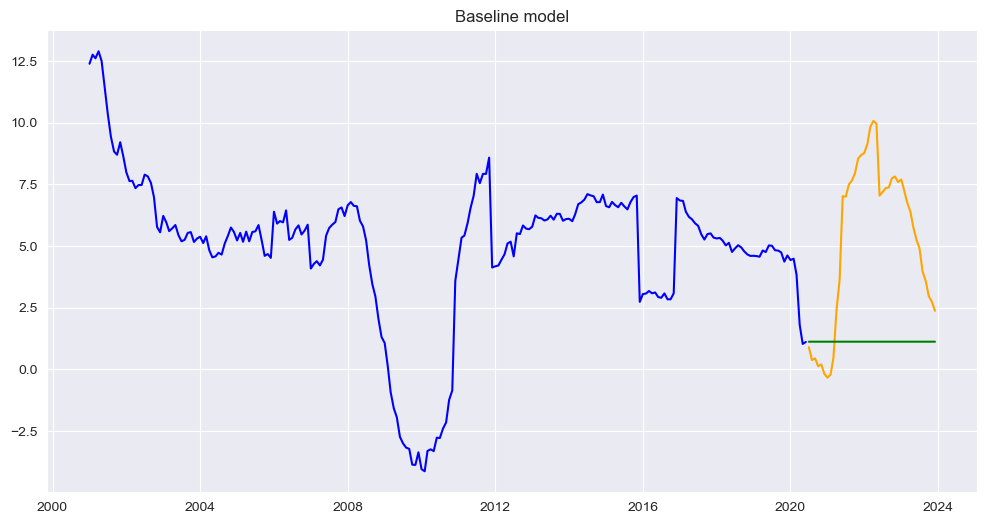

In [707]:
plt.figure(figsize=(12,6))

plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

plt.plot(y_test.index, preds_bl, color = 'green')

plt.title(label = 'Baseline model', fontsize=12);

In [708]:
print(arima_1_1_0.aic)


506.32953859277916


- Baseline model clearly not capturing the trend of credit growth. 

## SARIMA Model Hyperparameter Tuning (no exodogenous variables)

In [709]:
from pmdarima import auto_arima

In [710]:
sarima_model = auto_arima(y_train,
                       start_P=0,
                       start_q=0,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       max_Q=3, 
                       m=1, 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=506.313, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=507.979, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=507.473, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=507.955, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=507.048, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=508.219, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=506.916, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=505.245, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=506.927, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=507.171, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=508.265, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=503.803, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=506.864, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=506.330, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=505.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -248.901
Date:                Mon, 19 Feb 2024   AIC                            503.803
Time:                        20:38:37   BIC                            514.156
Sample:                    01-01-2001   HQIC                           507.978
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8034      0.206      3.906      0.000       0.400       1.207
ma.L1         -0.6971      0.261     -2.669      0.008      -1.209      -0.185
sigma2         0.4958      0.015     32.835      0.000       0.466       0.525
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              4575.69
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [711]:
sarima = SARIMAX(endog = y_train,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S) 
                seasonal = True, 
                shuffle = False)

# Fit SARIMAX model.
result = sarima.fit(disp=False)

# Generate predictions based on test set.
preds_noexog = result.predict(
                    start = datetime((int(str(y_test.index[0])[0:4])), 
                                        int(str(y_test.index[0])[5:7]), 
                                        int(str(y_test.index[0])[8:10])),
                    end = datetime((int(str(y_test.index[-1])[0:4])), 
                                    int(str(y_test.index[-1])[5:7]), 
                                    int(str(y_test.index[-1])[8:10])))

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


503.802972963528


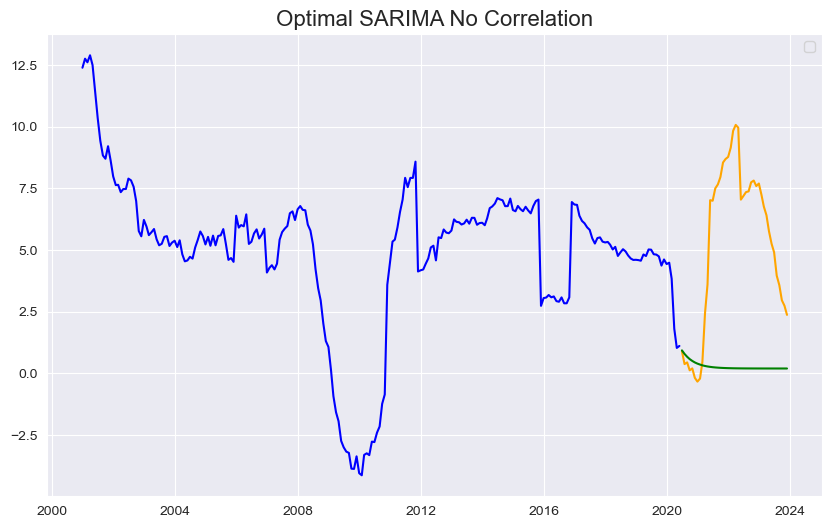

In [712]:
# Evaluate predictions.
print(result.aic)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds_noexog, color = 'green')
plt.title(label = 'Optimal SARIMA No Correlation', fontsize=16)
plt.legend()
plt.show();

- Again model clearly not capturing the trend of yoy credit growth over time, below we introduce some exogenous variables.

## SARIMAX model

Creating an intial model with exogenous variables, based on those over 30% positively or negatively correlated with credit growth. Avoiding those that are more than 75% correlated with one and other. 

In [713]:
df.drop(columns =['cc_rate_all_ns', 
                'cc_bals_30d_due_percentage_6m', 
                'cc_bals_30d_due_percentage_yoy_6m',
                'cc_bals_30d_due_percentage_yoy_3m',
                'cc_bals_90d_due_percentage_yoy',
                'cc_bals_30d_due_percentage_yoy',
                'Mortgage_servicing_yoy',
                'cc_payments_yoy',
                'cc_payments',
                'Mortgage_servicing',
                'cc_bals_90d_due_percentage.1',
                'cc_bals_30d_due_percentage.1',
                'Total',
                'Other',
                'Student Loan',
                'Credit Card',
                'Auto Loan',
                'HE Revolving',
                'Mortgage',
                'Qtr',
                'cc_balance_total_billions',
                'cc_bals_90d_due_percentage',
                'cc_bals_30d_due_percentage']).corr(numeric_only=True)['credit_yoy'].sort_values(ascending=False)

credit_yoy                                                         1.000000
shelter_yoy                                                        0.520146
cpi_yoy                                                            0.448303
gdp_yoy                                                            0.384757
food_yoy                                                           0.320199
fedfunds                                                           0.302536
energy_yoy                                                         0.299519
mortgage_rate_30_yr                                                0.248460
gasoline_yoy                                                       0.202741
all_less_food_&_shelter_yoy                                        0.184390
imports_yoy                                                        0.164761
tax_personal_current                                               0.136099
hourly_earnings_yoy                                                0.108193
medical_care

In [714]:
X_train, X_test, y_train_exog, y_test_exog = train_test_split(X,
                                                                y,
                                                                test_size = 0.15,
                                                                shuffle = False) 

In [715]:
X_train_exog = X_train[['personal_saving_as_a_percentage_of_disposable_personal_income', 
                        'unemployment_insurance',
                        'mortgage_rate_30_yr', 
                        'shelter_yoy', 
                        'unemployment_rate', 
                        'cpi_yoy',
                        'fedfunds',
                        'food_yoy',
                        'gdp_yoy']]
X_test_exog = X_test[['personal_saving_as_a_percentage_of_disposable_personal_income', 
                      'unemployment_insurance',
                      'mortgage_rate_30_yr', 
                      'shelter_yoy', 
                      'unemployment_rate', 
                      'cpi_yoy',
                      'fedfunds',
                      'food_yoy',
                      'gdp_yoy']]
                      

In [716]:
# source: https://sailajakarra.medium.com/time-series-predictions-using-arima-sarimax-e6724844cae0 

sarimax_model_exog = auto_arima(y_train_exog,
                       start_P=0,
                       start_q=0,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       exogenous = X_train_exog,
                       max_Q=3, 
                       m=1, # is monthly 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarimax_model_exog.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=506.313, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=507.979, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=507.473, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=507.955, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=507.048, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=508.219, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=506.916, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=505.245, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=506.927, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=507.171, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=508.265, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=503.803, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=506.864, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=506.330, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=505.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -248.901
Date:                Mon, 19 Feb 2024   AIC                            503.803
Time:                        20:38:39   BIC                            514.156
Sample:                    01-01-2001   HQIC                           507.978
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8034      0.206      3.906      0.000       0.400       1.207
ma.L1         -0.6971      0.261     -2.669      0.008      -1.209      -0.185
sigma2         0.4958      0.015     32.835      0.000       0.466       0.525
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              4575.69
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [717]:
sarimax_ex = SARIMAX(endog = y_train_exog,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_train_exog, 
                seasonal = True, 
                shuffle = False)

# Fit SARIMAX model.
results_s_ex = sarimax_ex.fit(disp=False)

# Generate predictions based on test set.
preds_s_ex = results_s_ex.predict(
                    start = datetime((int(str(y_test_exog.index[0])[0:4])), 
                                        int(str(y_test_exog.index[0])[5:7]), 
                                        int(str(y_test_exog.index[0])[8:10])),
                    end = datetime((int(str(y_test_exog.index[-1])[0:4])), 
                                    int(str(y_test_exog.index[-1])[5:7]), 
                                    int(str(y_test_exog.index[-1])[8:10])),
                    exog = X_test_exog)

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AaranD

AIC 498.3334941164123
Root Mean Squared Error: 0.9413363937175195


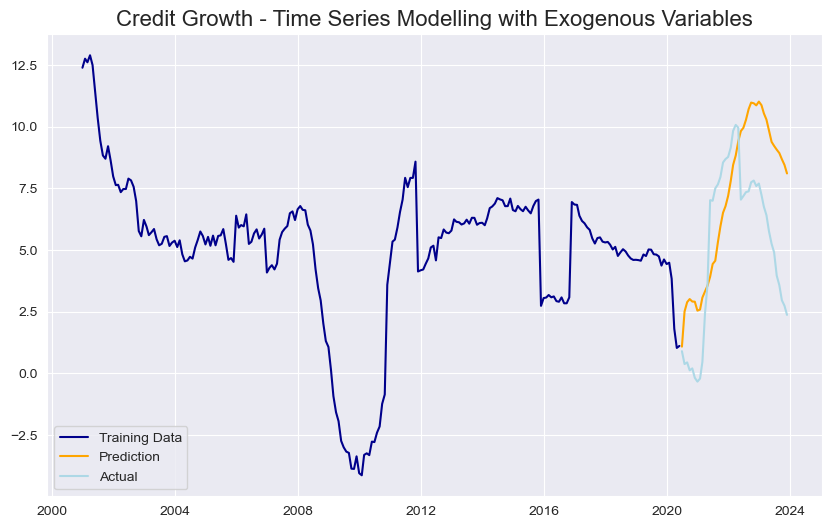

In [718]:

print('AIC', results_s_ex.aic)
print('Root Mean Squared Error:',np.sqrt(results_s_ex.mse))


plt.figure(figsize=(10, 6))
plt.plot(y_train_exog, color='darkblue', label='Training Data')
plt.plot(preds_s_ex, color='orange', label='Prediction')
plt.plot(y_test_exog, color='lightblue', label='Actual')
plt.title('Credit Growth - Time Series Modelling with Exogenous Variables', fontsize=16)
plt.legend()  
plt.show();

In [719]:
df['credit_yoy'].describe()

count    276.000000
mean       5.008511
std        3.084354
min       -4.125881
25%        4.423791
50%        5.516718
75%        6.655239
max       12.895804
Name: credit_yoy, dtype: float64

- Model tracking trend nicely when predicting a 3.5 year period, with comparison to test data which is actual. 
- AIC of 497 indicates quite good model fit and 
- RSME of 0.9% suggests good accuracy given the range of credit growth over this time period is 17%.

In [720]:
results_s_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             credit_yoy   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -237.167
Date:                Mon, 19 Feb 2024   AIC                            498.333
Time:                        20:38:40   BIC                            539.746
Sample:                    01-01-2001   HQIC                           515.033
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
personal_saving_as_a_percentage_of_disposable_personal_income     0.0226      0.243      0.093      0.926      -0.455       0.500
unemployment_insurance                                           -0.2170      1.379     -0.157      0.875      -2.920       2.486
mortgage_rate_30_yr                                               0.3705      0.352      1.051      0.293      -0.320       1.061
shelter_yoy                                                       0.6468      0.686      0.943      0.346      -0.698       1.992
unemployment_rate                                                -0.3605      0.450     -0.800      0.423      -1.243       0.522
cpi_yoy                                                           0.4100      0.296      1.383      0.167      -0.171       0.991
fedfunds                                                          0.3572      0.752      0.475      0.635      -1.117       1.831
food_yoy                                                          0.5418      0.425      1.273      0.203      -0.292       1.376
gdp_yoy                                                           0.0098      0.549      0.018      0.986      -1.066       1.086
ar.L1                                                            -0.7183      1.337     -0.537      0.591      -3.340       1.903
ma.L1                                                             0.6910      1.410      0.490      0.624      -2.072       3.454
sigma2                                                            0.4484      0.020     22.340      0.000       0.409       0.488
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):              4918.27
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.74
Prob(H) (two-sided):                  0.04   Kurtosis:                        25.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Highest positive coefficient (exogenous variable) from the model was shelter yoy inflation at 0.64. We can interpret this as, when shelter inflation increases by one standard deviation, the credit yoy is expected to increase by 0.64%, all else being equal.
- Interestingly unemployment_rate was the lowest coefficient in the model at -0.36. We can interpret this as, when unemoployment rate increases by one standard deviation, the credit yoy is expected to decrease by 0.36%, all else being equal.
- We might reccomend, considering low unemployment and high shelter inflation as signs that credit growth might be strong. 
- CPI, food yoy also positive coefficients when they rise so does credit growth according to the model. 
- Fed funds and relatedly the 30 year mortage rate were as to be expected positive coeffiecnts at 0.36 and 0.37 respectivley. 

## Try with pre-covid only data

In [721]:
X_train_precov, X_test_precov, y_train_precov, y_test_precov = train_test_split(X,
                                                    y,
                                                    test_size = 0.17,
                                                    shuffle = False) 

In [722]:
sarimax_model_precov = auto_arima(y_train_precov,
                       start_P=0,
                       start_q=0,
                       exogenous = X_train_precov,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       max_Q=3, 
                       m=1, # is monthly 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarimax_model_precov.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=491.372, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=492.544, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=492.854, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=493.192, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=491.099, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=490.510, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=491.876, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=491.899, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=492.312, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=493.121, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=488.779, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=491.679, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=491.319, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=490.138, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=490.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -241.390
Date:                Mon, 19 Feb 2024   AIC                            488.779
Time:                        20:38:41   BIC                            499.067
Sample:                    01-01-2001   HQIC                           492.930
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      0.209      3.858      0.000       0.397       1.216
ma.L1         -0.7081      0.266     -2.661      0.008      -1.230      -0.187
sigma2         0.4864      0.015     32.745      0.000       0.457       0.516
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              5004.61
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                            -0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                        25.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

AIC 510.78426338520296
Root Mean Squared Error: 0.6707889522879595


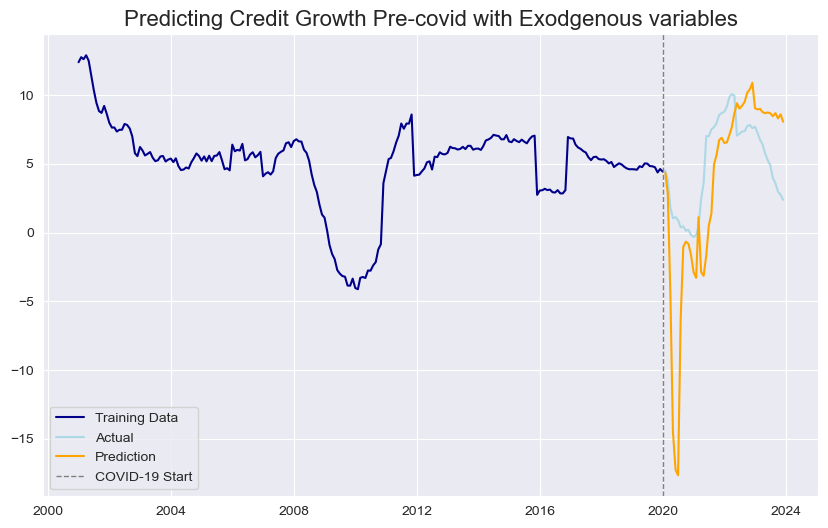

In [723]:
sarimax_precov = SARIMAX(endog = y_train_precov,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_train_precov, 
                seasonal = True, 
                shuffle = False)

results_precov = sarimax_precov.fit(disp=False)

preds_precov = results_precov.predict(
                    start = datetime((int(str(y_test_precov.index[0])[0:4])), 
                                        int(str(y_test_precov.index[0])[5:7]), 
                                        int(str(y_test_precov.index[0])[8:10])),
                    end = datetime((int(str(y_test_precov.index[-1])[0:4])), 
                                    int(str(y_test_precov.index[-1])[5:7]), 
                                    int(str(y_test_precov.index[-1])[8:10])),
                    exog = X_test_precov)

print('AIC', results_precov.aic)

print('Root Mean Squared Error:',np.sqrt(results_precov.mse))

plt.figure(figsize=(10,6))
plt.plot(y_train_precov, color='darkblue', label='Training Data')
plt.plot(y_test_precov, color='lightblue', label='Actual')
plt.plot(preds_precov, color='orange', label='Prediction')
plt.title(label = 'Predicting Credit Growth Pre-covid with Exodgenous variables', fontsize=16)
plt.axvline(pd.Timestamp('2020-01-10'), color='grey', linestyle='--', lw=1, label='COVID-19 Start')
plt.legend()  
plt.show();

- As might be expected the models performance worsens when provided with less training data. 2% less in this case. Which brings the train period to before covid. 
- Also given an exceptional economic and cultural shock like covid, the model might be expected to have unaccurate predictions. 
- We see the model predicting a huge fall in credit growth from Feb 1st 2020. 

# Training Model on All Data and Predicting Future Credit Growth

In [724]:
last_date = df.index.max()
last_date

Timestamp('2023-12-01 00:00:00')

In [725]:
extended_date_range = pd.date_range(start=last_date, periods=13, freq='MS')

In [726]:
df_ext = df.reindex(df.index.union(extended_date_range))
df_ext.shape

(288, 68)

In [727]:
X_f = df_ext.drop(columns=m_coliniarity).copy()
y_f = df_ext['credit_yoy']

In [728]:
X_f

,population,unemployment_rate,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,new_&_used_vehicles_yoy,...,total_all_personal_outlays,personal_interest_payments,tax_other_to_government,tax_personal_current,tax_gov_social_insurance_domestic,tax_total_all_taxes,mortgage_rate_30_yr,gdp,gdp_yoy,fedfunds
2001-01-01,283960000.0,4.2,3.732227,3.252886,17.777778,4.538341,2.889825,13.143736,2.760736,1.394422,...,7.306994e+12,2.310750e+11,5.118800e+10,1.289199e+12,7.281720e+11,2.068559e+12,7.0325,10470.231000,4.679500,5.98
2001-02-01,284166000.0,4.2,3.533569,3.457307,13.110540,4.600390,3.006615,8.400292,0.200602,1.800000,...,7.321676e+12,2.309880e+11,5.152400e+10,1.303434e+12,7.330290e+11,2.087987e+12,7.0500,10513.154000,4.255523,5.49
2001-03-01,284380000.0,4.3,2.920561,3.496868,5.973813,4.540163,3.123123,-6.099935,-1.601602,1.397206,...,7.316277e+12,2.303920e+11,5.189600e+10,1.313079e+12,7.357760e+11,2.100751e+12,6.9520,10556.077000,3.838372,5.31
2001-04-01,284602000.0,4.4,3.269119,3.595623,10.273405,4.643963,3.181273,3.851262,-0.710660,1.094527,...,7.324515e+12,2.300380e+11,5.212400e+10,1.315105e+12,7.335270e+11,2.100756e+12,7.0775,10599.000000,3.427884,4.80
2001-05-01,284834000.0,4.3,3.615160,3.742204,15.785124,4.668210,3.108189,15.420561,-0.809717,0.495540,...,7.372343e+12,2.289890e+11,5.246000e+10,1.310869e+12,7.328300e+11,2.096159e+12,7.1450,10598.673333,3.188251,4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [729]:
for column in X_f.columns:
    X_f[f"{column}_shift12m"] = X_f[column].shift(12)

X_f

,population,unemployment_rate,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,new_&_used_vehicles_yoy,...,total_all_personal_outlays_shift12m,personal_interest_payments_shift12m,tax_other_to_government_shift12m,tax_personal_current_shift12m,tax_gov_social_insurance_domestic_shift12m,tax_total_all_taxes_shift12m,mortgage_rate_30_yr_shift12m,gdp_shift12m,gdp_yoy_shift12m,fedfunds_shift12m
2001-01-01,283960000.0,4.2,3.732227,3.252886,17.777778,4.538341,2.889825,13.143736,2.760736,1.394422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-01,284166000.0,4.2,3.533569,3.457307,13.110540,4.600390,3.006615,8.400292,0.200602,1.800000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-01,284380000.0,4.3,2.920561,3.496868,5.973813,4.540163,3.123123,-6.099935,-1.601602,1.397206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-01,284602000.0,4.4,3.269119,3.595623,10.273405,4.643963,3.181273,3.851262,-0.710660,1.094527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-01,284834000.0,4.3,3.615160,3.742204,15.785124,4.668210,3.108189,15.420561,-0.809717,0.495540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.941698e+13,5.190220e+11,1.311930e+11,2.759355e+12,1.814347e+12,4.704895e+12,7.072,27719.695667,6.073399,5.33
2024-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.960094e+13,5.628410e+11,1.314810e+11,2.770345e+12,1.820744e+12,4.722570e+12,7.200,27829.263333,5.933581,5.33
2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.960629e+13,5.633020e+11,1.317850e+11,2.762721e+12,1.824036e+12,4.718542e+12,7.620,27938.831000,5.795223,5.33
2024-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.968022e+13,5.637630e+11,1.321240e+11,2.768969e+12,1.833091e+12,4.734184e+12,7.442,27968.902300,5.370179,5.33


In [730]:
X_f.columns

Index(['population', 'unemployment_rate', 'cpi_yoy', 'shelter_yoy',
       'energy_yoy', 'medical_care_yoy', 'food_yoy', 'gasoline_yoy',
       'imports_yoy', 'new_&_used_vehicles_yoy', 'all_less_food_&_shelter_yoy',
       'total_personal_income', 'total_employee_compensation',
       'wages_and_salaries_all', 'wages_salaries_private_employees',
       'wages_salaries_government_employees',
       'employer_contributions_for_employee_pension_and_insurance_funds',
       'employer_contributions_for_government_social_insurance',
       'rental_income_(capital_consumption_adjusted)',
       'personal_dividend_income', 'personal_interest_income',
       'total_gov_social_benefits', 'social_security', 'medicare', 'medicaid',
       'unemployment_insurance', 'veterans'_benefits',
       'total_disposible_personal_income_chained_2017',
       'total_personal_savings',
       'personal_saving_as_a_percentage_of_disposable_personal_income',
       'disp_inc_per_capita_chained_2017', 'total_dis

In [731]:
X_f.drop(columns = ['population', 'unemployment_rate', 'cpi_yoy', 'shelter_yoy',
       'energy_yoy', 'medical_care_yoy', 'food_yoy', 'gasoline_yoy',
       'imports_yoy', 'new_&_used_vehicles_yoy', 'all_less_food_&_shelter_yoy',
       'total_personal_income', 'total_employee_compensation',
       'wages_and_salaries_all', 'wages_salaries_private_employees',
       'wages_salaries_government_employees',
       'employer_contributions_for_employee_pension_and_insurance_funds',
       'employer_contributions_for_government_social_insurance',
       'rental_income_(capital_consumption_adjusted)',
       'personal_dividend_income', 'personal_interest_income',
       'total_gov_social_benefits', 'social_security', 'medicare', 'medicaid',
       'unemployment_insurance', "veterans'_benefits",
       'total_disposible_personal_income_chained_2017',
       'total_personal_savings',
       'personal_saving_as_a_percentage_of_disposable_personal_income',
       'disp_inc_per_capita_chained_2017', 'total_disposable_personal_income',
       'disp_inc_per_capita_current_dollars', 'total_all_personal_outlays',
       'personal_interest_payments', 'tax_other_to_government',
       'tax_personal_current', 'tax_gov_social_insurance_domestic',
       'tax_total_all_taxes', 'mortgage_rate_30_yr', 'gdp', 'gdp_yoy',
       'fedfunds'], inplace=True)

In [732]:
X_f_train = X_f.first('276M').copy() # 2002-23
X_f_validation = X_f.last('12M').copy() # 2023-24 to be used for forcasting
y_f_train = y_f.first('276M').copy()  # 2002-23
y_f_validation = y_f.last('12M').copy()  # 2023-24 used to check forcasting?

In [733]:
X_f_train.dropna(inplace=True)
X_f_validation.dropna(inplace=True)
y_f_train.dropna(inplace=True) 

In [734]:
y_f_train = y_f_train.last('264M')

In [735]:
# check sizes of all 
print(X_f_train.shape)
print(X_f_validation.shape)
print(y_f_train.shape)
print(y_f_validation.shape)

(264, 43)
(12, 43)
(264,)
(12,)


In [736]:
sarimax_forecast = SARIMAX(endog = y_f_train,
                order = (1,1,1),             # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_f_train, 
                seasonal = True, 
                shuffle = False)

results_forecast = sarimax_forecast.fit(disp=False)

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [737]:
preds_forecast = results_forecast.predict(
                                        start = datetime(2023, 12, 1),
                                        end = datetime(2024, 12, 1),         
                                        exog = X_f_validation)

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


498.3334941164123


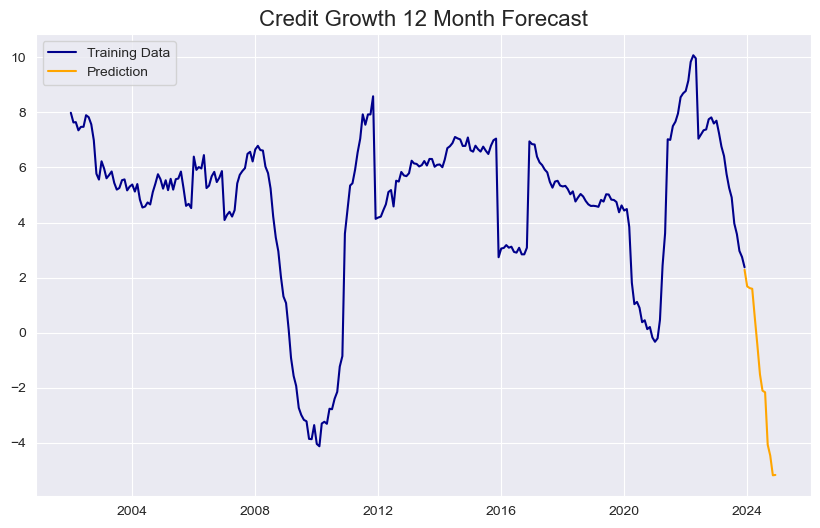

In [738]:
# Evaluate predictions.
print(results_s_ex.aic)

# Plot data.
plt.figure(figsize=(10, 6))
plt.plot(y_f_train, color='darkblue', label='Training Data')
plt.plot(preds_forecast, color='orange', label='Prediction')
plt.title('Credit Growth 12 Month Forecast', fontsize=16)
plt.legend()  
plt.show();

- Based on our forecast credit growth is expected to fall into negative levels over the next 12 months perhaps levelling out towards the end of the year. 
- Although perhaps we cannot completely trust the amplitude of the forecasts, we have seen that the model even when predicting precovid is largely directionally correct. 
- On this basis we would advice the credit card company we are consulting to plan for negative credict growth over the coming 12 months. 